In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt

from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model
from keras.initializers import RandomNormal
from keras.optimizers import Adam

from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle

from wasserstein_loss import wasserstein_generator_loss, wasserstein_discriminator_loss
from image_wgan_gp import imageWGANGP
from GANmonitor import GANMonitor

In [2]:
import warnings
warnings.filterwarnings('ignore')

# GAN model

In [3]:
def upsample_block(x, filters, size, strides, upsize, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    x = layers.UpSampling2D(upsize)(x)
    x = layers.Conv2D(
        filters, size, strides=strides, padding="same", use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)
    if apply_dropout:
        x = layers.Dropout(0.5)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    return x

def convolution_block(x, filters, size, strides, apply_batchnorm=False, apply_layernorm=True, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    x = layers.Conv2D(filters, size, strides=strides, padding='same',
                                    kernel_initializer=initializer, use_bias=False)(x)
    if apply_batchnorm:
        # don't EVER use batchnorm in WGAN models
        # unless of course you like loss in billions, then be my guest
        x = layers.BatchNormalization()(x)
    if apply_layernorm:
        x = layers.LayerNormalization()(x)
    if apply_dropout:
        x = layers.Dropout(0.3)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    return x

In [4]:
def build_generator(latent_dim=128, num_classes=10, img_height=28, img_width=28, img_channels=1):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    in_channels = latent_dim+num_classes
    inputs = layers.Input((in_channels,))
    
    x = inputs
    
    x = layers.Dense(4*4*in_channels)(x)
    x = layers.Reshape((4,4,in_channels))(x)
    
    x = upsample_block(x, filters = 256, size = 3, strides = 1, upsize = (2,2))
    x = upsample_block(x, filters = 128, size = 3, strides = 1, upsize = (2,2))
    x = upsample_block(x, filters = 64, size = 3, strides = 1, upsize = (2,2))
    
    last = tf.keras.layers.Conv2D(img_channels, 7,
                                 padding='same',
                                 kernel_initializer=initializer,
                                 activation='tanh')
        
    x = last(x)
    # output shape should be (28,28), need to crop from (32,32)
    x = layers.Cropping2D((2, 2))(x)
    
    return Model(inputs=inputs, outputs=x,name="generator")

In [5]:
def build_discriminator(num_classes=10, img_height=28, img_width=28, img_channels=1):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = layers.Input((img_height,img_width,img_channels))
    label = layers.Input((img_height,img_width,num_classes))
    
    x = layers.concatenate([inp, label])
    # input shape is (28,28), need to fix it to (32,32)
    x = layers.ZeroPadding2D((2, 2))(x)
    
    x = convolution_block(x, filters=64, size = 5, strides = 2)
    x = convolution_block(x, filters=128, size = 5, strides = 2, apply_dropout = True)
    x = convolution_block(x, filters=256, size = 5, strides = 2, apply_dropout = True)
    x = convolution_block(x, filters=512, size = 5, strides = 2)
    
    flatten = layers.Flatten()
    last = layers.Dense(1)
    
    x = flatten(x)
    x = layers.Dropout(0.2)(x)
    x = last(x)
    
    return Model(inputs=[inp,label], outputs=x, name="discriminator")

# Test data

In [13]:
batch_size = 512
img_channels = 1
num_classes = 10
img_height = 28
img_width = 28
latent_dim = 128

In [36]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = (x_train.astype("float32") - 127.5) / 127.5
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = keras.utils.to_categorical(y_train, num_classes)

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
dataset_test = dataset_test.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {x_train.shape}")
print(f"Shape of training labels: {y_train.shape}")

Shape of training images: (60000, 28, 28, 1)
Shape of training labels: (60000, 10)


In [8]:
discriminator = build_discriminator()

In [9]:
generator = build_generator()

In [14]:
mnistgan = imageWGANGP(generator,discriminator,latent_dim = latent_dim, num_classes = num_classes,
                        img_height = img_height, img_width = img_width, img_channels = img_channels)
mnistgan.compile(
    discriminator_optimizer=Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9),
    generator_optimizer=Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9),
    discriminator_loss = wasserstein_discriminator_loss,
    generator_loss = wasserstein_generator_loss
)

In [15]:
# callbacks to save images and checkpoints
cbk = GANMonitor()
checkpoint_path = "checkpoints_mnist/mnist_{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True)

In [16]:
#mnistgan.fit(dataset, epochs=50, batch_size = batch_size, callbacks=[cbk, cp_callback])

Epoch 1/50
118/118 [==============================] - 260s 2s/step - g_loss: 6.8448 - d_loss: -6.9284
Epoch 2/50
118/118 [==============================] - 221s 2s/step - g_loss: 4.3496 - d_loss: -5.7635
Epoch 3/50
118/118 [==============================] - 222s 2s/step - g_loss: 2.5135 - d_loss: -4.0576
Epoch 4/50
118/118 [==============================] - 222s 2s/step - g_loss: 0.7783 - d_loss: -3.2612
Epoch 5/50
118/118 [==============================] - 222s 2s/step - g_loss: -0.8342 - d_loss: -2.8720
Epoch 6/50
118/118 [==============================] - 222s 2s/step - g_loss: -1.3930 - d_loss: -2.4482
Epoch 7/50
118/118 [==============================] - 222s 2s/step - g_loss: -1.3496 - d_loss: -2.2990
Epoch 8/50
118/118 [==============================] - 222s 2s/step - g_loss: -2.0630 - d_loss: -2.2216
Epoch 9/50
118/118 [==============================] - 222s 2s/step - g_loss: -2.4647 - d_loss: -2.1292
Epoch 10/50
118/118 [==============================] - 222s 2s/step - g_loss:

In [15]:
mnistgan.load_weights("checkpoints_mnist/mnist_0050.ckpt")

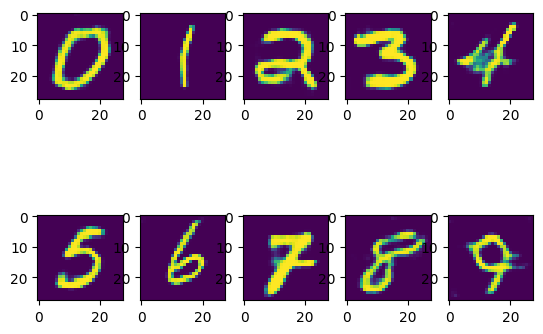

In [16]:
fig, axs = plt.subplots(2,5)
for i in range(10):
    arr = np.zeros((1,10))
    arr[0][i] = 1
    noise = tf.random.normal(shape=(1, latent_dim))
    img = mnistgan.generator(tf.concat([noise, arr], axis = 1))
    img = img.numpy()
    img = img * 127.5 + 127.5
    img = img.reshape((28,28))
    axs[i//5][i%5].imshow(img)
plt.show()

In [22]:
# create a demo MNIST image
random_latent_vectors = tf.random.normal(shape=(100, latent_dim))
arr = np.zeros((100,num_classes))
for i in range(10):
    for j in range(10):
        arr[i*10+j][i] = 1
random_latent_vectors = tf.concat([random_latent_vectors,arr], axis = 1)
generated_images = mnistgan.generator(random_latent_vectors)
generated_images = (generated_images * 127.5) + 127.5

img = []
for i in range(10):
    img.append([])
    for j in range(10):
        numpy_img = generated_images[i*10+j].numpy()
        img[i].append(numpy_img)
img = np.array(img)
img = np.hstack(np.hstack(img))
print(img.shape)
img = img.reshape((img_height*10, img_width*10, img_channels))
img = keras.preprocessing.image.array_to_img(img)
img.save(f"mnist_demo.png")

(280, 280, 1)


## Generating mnist digits

In [71]:
img_list = []
label_list = []
for label in range(10):
    for _ in range(100):
        random_latent_vectors = tf.random.normal(shape=(60, latent_dim))
        labels = np.full((60), label)
        labels = keras.utils.to_categorical(labels,num_classes)
        random_latent_vectors = tf.concat([random_latent_vectors,labels], axis = 1)
        generated_imgs = mnistgan.generator(random_latent_vectors)
        img_list.append(generated_imgs)
        label_list.append(labels)
generated_images = tf.reshape(tf.stack(img_list), [60000, 28, 28, 1])
generated_labels = tf.reshape(tf.stack(label_list), [60000, 10])

In [72]:
generated_labels = np.argmax(generated_labels, axis = -1)

In [49]:
y_train = np.argmax(y_train, axis = -1)

## Building a simple classifier

In [73]:
def make_classifier():
    classifier = Sequential([
      layers.Flatten(input_shape=(28, 28, 1)),
      layers.Dense(128, activation='relu'),
      layers.Dense(10)
    ])
    classifier.compile(
        optimizer=Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )
    return classifier

In [74]:
classifier1 = make_classifier()
classifier2 = make_classifier()

## Training the classifier and testing it on real data

In [75]:
# training on real data
classifier1.fit(x_train, y_train, epochs = 10, batch_size = batch_size, validation_data=(x_test, y_test))

Epoch 1/10
118/118 [==============================] - 1s 5ms/step - loss: 0.5770 - sparse_categorical_accuracy: 0.8272 - val_loss: 39.9093 - val_sparse_categorical_accuracy: 0.7425
Epoch 2/10
118/118 [==============================] - 0s 3ms/step - loss: 0.2879 - sparse_categorical_accuracy: 0.9176 - val_loss: 30.9943 - val_sparse_categorical_accuracy: 0.8106
Epoch 3/10
118/118 [==============================] - 0s 3ms/step - loss: 0.2288 - sparse_categorical_accuracy: 0.9350 - val_loss: 27.0759 - val_sparse_categorical_accuracy: 0.8496
Epoch 4/10
118/118 [==============================] - 0s 4ms/step - loss: 0.1926 - sparse_categorical_accuracy: 0.9454 - val_loss: 23.4471 - val_sparse_categorical_accuracy: 0.8750
Epoch 5/10
118/118 [==============================] - 0s 3ms/step - loss: 0.1632 - sparse_categorical_accuracy: 0.9536 - val_loss: 22.4239 - val_sparse_categorical_accuracy: 0.8837
Epoch 6/10
118/118 [==============================] - 0s 3ms/step - loss: 0.1434 - sparse_categ

In [76]:
# training on generated data
classifier2.fit(generated_images, generated_labels, epochs = 10, batch_size = batch_size, validation_data=(x_test, y_test))

Epoch 1/10
118/118 [==============================] - 1s 5ms/step - loss: 0.4675 - sparse_categorical_accuracy: 0.8605 - val_loss: 31.6447 - val_sparse_categorical_accuracy: 0.7849
Epoch 2/10
118/118 [==============================] - 0s 3ms/step - loss: 0.1963 - sparse_categorical_accuracy: 0.9429 - val_loss: 26.6975 - val_sparse_categorical_accuracy: 0.8377
Epoch 3/10
118/118 [==============================] - 0s 3ms/step - loss: 0.1435 - sparse_categorical_accuracy: 0.9585 - val_loss: 25.1512 - val_sparse_categorical_accuracy: 0.8583
Epoch 4/10
118/118 [==============================] - 0s 3ms/step - loss: 0.1140 - sparse_categorical_accuracy: 0.9671 - val_loss: 24.7255 - val_sparse_categorical_accuracy: 0.8691
Epoch 5/10
118/118 [==============================] - 0s 3ms/step - loss: 0.0927 - sparse_categorical_accuracy: 0.9729 - val_loss: 24.4235 - val_sparse_categorical_accuracy: 0.8815
Epoch 6/10
118/118 [==============================] - 0s 3ms/step - loss: 0.0766 - sparse_categ